# Florence-2-large sample usage

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import copy
import torch
%matplotlib inline

In [ ]:
!pip install timm flash_attn einops

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

## define the prediction function

In [ ]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [ ]:
chemin_image = "images.png"
image = Image.open(chemin_image)
image = image.convert("RGB")

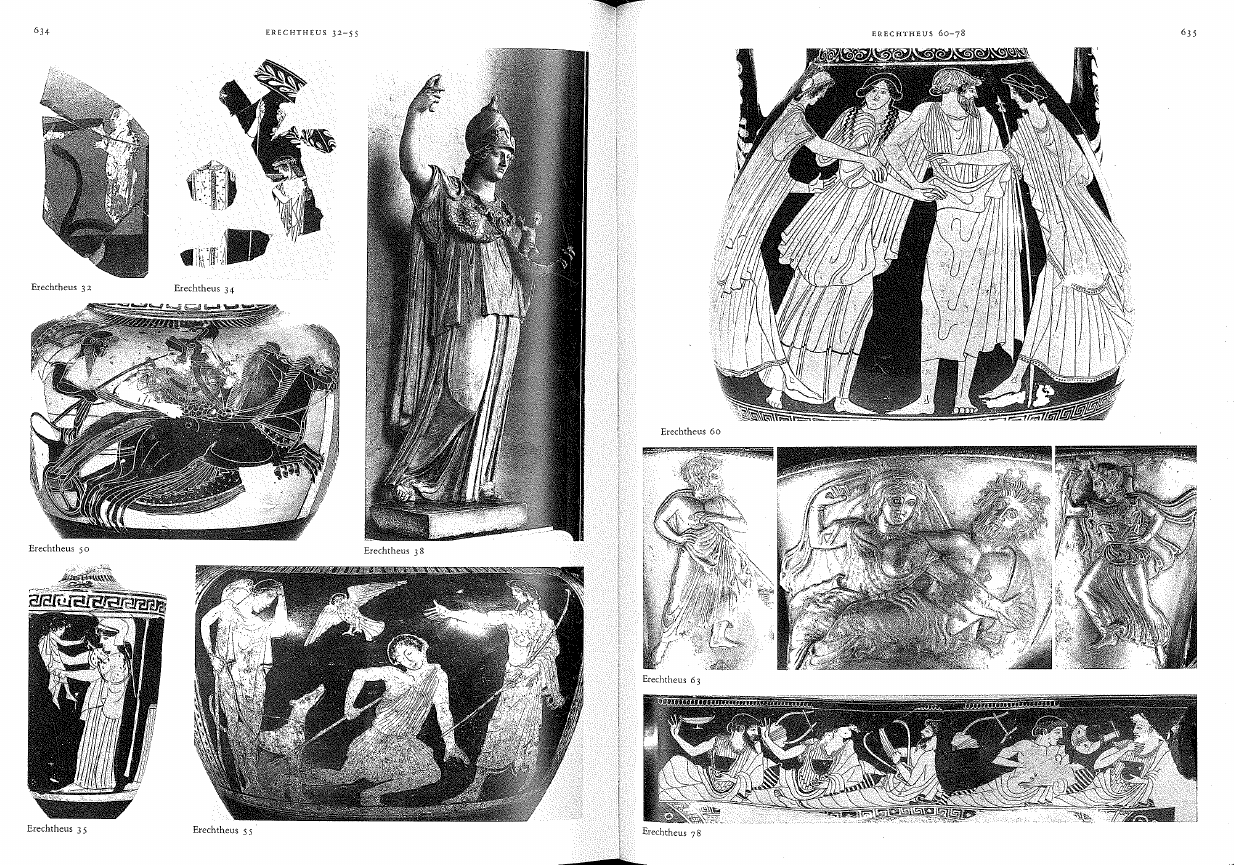

In [ ]:
image

## Run pre-defined tasks without additional inputs

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [ ]:
task_prompt = 'Hello, imagine you are an archivist tasked with extracting each visual representations from this document. Each item must has a image and a caption.'
results = run_example(task_prompt)
print(results)

{'Hello, imagine you are an archivist tasked with extracting each visual representations from this document. Each item must has a image and a caption.': 'an archivist tasked<loc_573><loc_52><loc_920><loc_487>Each item<loc_573><loc_52><loc_921><loc_487>'}


In [ ]:
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

### Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

### Region proposal

Region proposal results format:
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [ ]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[711.4010009765625, 67.0374984741211, 1135.89697265625, 417.3625183105469], [198.05699157714844, 578.2525024414062, 568.2569580078125, 808.342529296875], [384.3909912109375, 73.09249877929688, 544.8109741210938, 505.5924987792969], [708.9329833984375, 70.49749755859375, 892.7989501953125, 410.4425048828125], [763.22900390625, 73.09249877929688, 942.1589965820312, 414.76751708984375], [32.70100021362305, 323.9425048828125, 335.031005859375, 528.947509765625], [863.1829833984375, 67.0374984741211, 1027.304931640625, 415.63250732421875], [655.8709716796875, 710.5975341796875, 1198.8309326171875, 822.1824951171875], [979.178955078125, 73.09249877929688, 1137.1309814453125, 408.7124938964844], [784.2069702148438, 470.12750244140625, 1047.0489501953125, 669.9425048828125], [655.8709716796875, 711.4625244140625, 945.8609619140625, 810.9375], [422.6449890136719, 582.5775146484375, 567.0230102539062, 804.0175170898438], [1061.85693359375, 460.6125183105469, 119

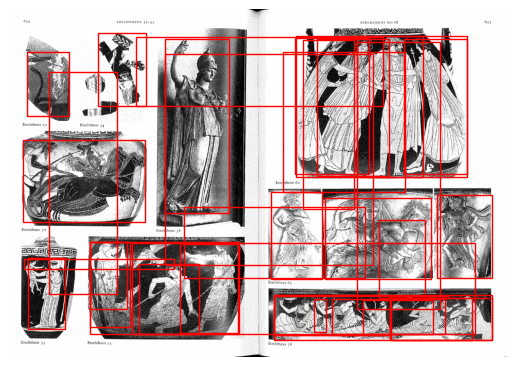

In [ ]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [ ]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="An illustration.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[708.9329833984375, 45.41250228881836, 1134.6629638671875, 420.822509765625], [193.12100219726562, 566.1425170898438, 584.2990112304688, 821.3175048828125], [368.3489990234375, 70.49749755859375, 575.6610107421875, 538.4625244140625], [27.764999389648438, 300.5874938964844, 339.96697998046875, 539.3275146484375], [643.531005859375, 695.8925170898438, 1197.596923828125, 823.9125366210938], [776.802978515625, 451.9624938964844, 1056.9210205078125, 669.9425048828125], [26.5310001373291, 564.4125366210938, 167.20700073242188, 819.5875244140625]], 'labels': ['An illustration', 'An illustration', 'An illustration', 'An illustration', 'An illustration', 'An illustration', 'An illustration']}}


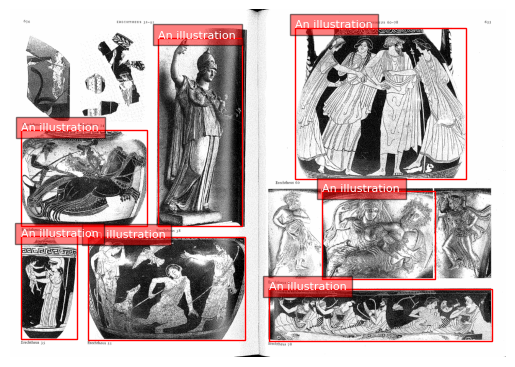

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [ ]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a dragon")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.23999786376953, 158.63999938964844, 582.0800170898438, 374.1600036621094]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [ ]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [ ]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

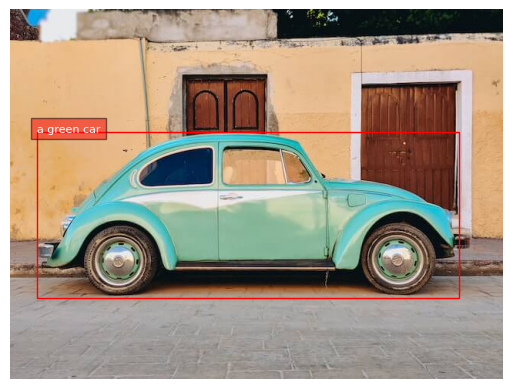

In [ ]:
plot_bbox(image, bbox_results)